In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Initially we wanted to use a word-level encoder that is a BERT model finetuned with medical text data.  This model was not very effective.

In [ ]:
from transformers import AutoTokenizer, AutoModel
tz = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
medBert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# these dudes did not work!!!

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch

device = torch.device("cuda")
#model = model.to(device)

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Load the pre-trained Sentence-BERT model
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
#model = SentenceTransformer('all-mpnet-base-v2')


# Load the document corpus into a DataFrame
diseases = pd.read_csv('masked.csv')

In [ ]:
# we want to encode faily long spans of text, so we increase max span len
model.max_seq_length = 256

Semantic embeddings - the process of representing words or phrases as vectors in a high-dimensional space, where words that have similar meanings are located close to each other in that space. The main idea behind this technique is that words with similar meanings tend to appear in similar contexts, so by analyzing large amounts of text data, we can learn to represent words and phrases as vectors that capture their meaning and relationships to other words and phrases.

Older text embeddings had fixed embeddings for words, which fails for words that have different meanings in different contexts.  Modern text embeddings dynamically embed words based off of their context.  For this project we will actually want to use Sentence Embeddings since it makes comparing longer text spans like the descriptions in our dataset much easier!

In [ ]:
# Get sentence embeddings for each document
description_embeddings = model.encode(diseases['description'].values)

In [ ]:
diseases['description_embeddings'] = pd.Series([emb for emb in description_embeddings])

We create clusters based on the embeddings of the disease descriptions.  We can use these clusters to color our plots in order to see how the examples move around the embedding space!

In [ ]:
num_clusters = 3
kmeans_model = KMeans(n_clusters=num_clusters)
kmeans_model.fit(description_embeddings)
labels = kmeans_model.labels_
diseases['description_cluster_labels'] = labels

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


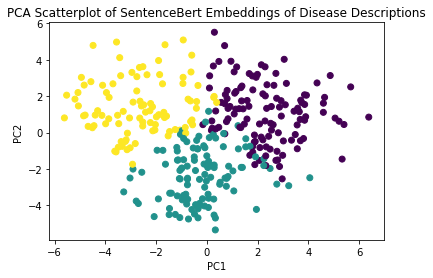

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components1 = pca.fit_transform(description_embeddings)

plt.scatter(components1[:,0], components1[:,1],c=labels)
plt.title('PCA Scatterplot of SentenceBert Embeddings of Disease Descriptions')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Note, we see some overlapping clusters here because we clustered in high-dimensional space, and then projected down to 2-space. However we generally see a pretty even distribution over the embedding space.  There are a few clumps which could correspond to the diseases with different varients in the dataset (ie Spastic paraplegia type 11, Spastic paraplegia type 49).  

In [ ]:
causes_embeddings = model.encode(diseases['causes'].values)

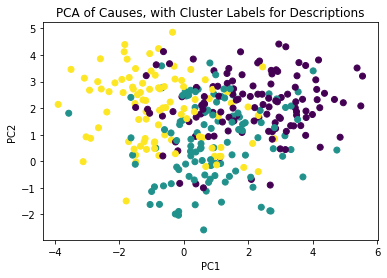

In [ ]:
components = pca.transform(causes_embeddings)

plt.scatter(components[:,0], components[:,1],c=labels)
plt.title('PCA of Causes, with Cluster Labels for Descriptions')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

We now plot out the embeddings of the "causes" embeddings.  We are coloring this plot with the cluster labels of the descriptions. What's exciting about this is that the examples clearly stay in the same areas of the semantic space as before, although there is a bit of drift. This suggests that a bi-encoder with cosine similarity could be an effective strategy for matching causes and descriptions. Note, there is a bit of "cheating" here as the causes also have the disease name!

In [ ]:
causes_masked_embeddings = model.encode(diseases['causes_masked'].values)

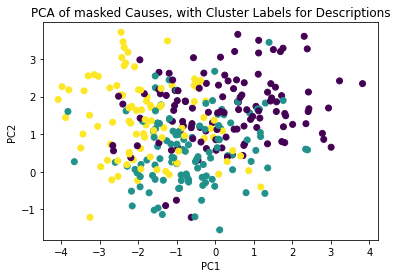

In [ ]:
components2 = pca.transform(causes_masked_embeddings)

plt.scatter(components2[:,0], components2[:,1],c=labels)
plt.title('PCA of masked Causes, with Cluster Labels for Descriptions')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

When we mask out the names and other tokens found in the descriptions, we see that the cause embeddings drift a bit more, which is what we would expect. However - we most of the examples stay in the same area as the original cluster.

I now hope to show different cluster centers for "causes" and "descriptions", which would suggest we need to use contrastive learning (explained in greater detail later).  

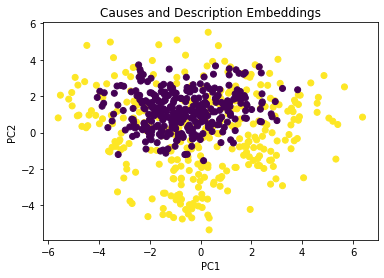

In [ ]:
cd_pca =np.concatenate((components1, components2), axis=0)
cd_labels = np.array([1 for i in range(components1.shape[0])]
                     +[0 for i in range(components2.shape[0])])
plt.scatter(cd_pca[:,0], cd_pca[:,1],c=cd_labels)
plt.title('Causes and Description Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


The (masked) causes embeddings are more tightly packed than the description embeddings, but appear to have the same distribution.  This suggests we may need to "fix" our description embeddings in some way before doing a semantic similarity comparison. This fix could take the form of a projection, a scaling, the addition of a "relation" vector.  

Task: We want to match disease descriptions to their causes.  We are casting this as a binary choice: given a description, can we choose correctly between the actual cause and a random cause sampled from somewhere else in the dataset.  

Now we will try a bi-encoder model. With a bi-encoder model we encode both text spans, then we use cosin similarity to match the embeddings.  

In [ ]:
import torch.nn as nn
import random

def rand_exclude(max, ind):
    return random.choice(list(set(list(range(max)))-set([ind])))

def eval_bi_encoder(embs1, embs2, ret = False):
  num_correct = 0
  num_total = len(embs1)
  cos = nn.CosineSimilarity(dim=0, eps=1e-6)
  for i in range(len(embs1)):
    pos_pair = (torch.Tensor(embs1[i]),torch.Tensor(embs2[i]))
    neg_pair = (torch.Tensor(embs1[i]),torch.Tensor((embs2[rand_exclude(num_total, i)])))
    if cos(pos_pair[0], pos_pair[1]) >= cos(neg_pair[0], neg_pair[1]):
      num_correct += 1
  if ret:
    return num_correct/num_total
  else: 
    print("Accuracy of BI-encoder:", num_correct/num_total)

# when we are evaling bi_encoder over fewer samples we may want to run multiple
# trials so that we decrease the variance of our accuracy 
#(as it depends on randomly generated pairs)
def strong_eval_bi_encoder(embs1, embs2, trials = 10):
    accs = []
    for i in range(trials):
      accs.append(eval_bi_encoder(embs1, embs2, ret = True))
    return np.array(accs).mean()


In [ ]:
eval_bi_encoder(description_embeddings,causes_embeddings)
eval_bi_encoder(description_embeddings,causes_masked_embeddings)

Accuracy of BI-encoder: 0.8558282208588958
Accuracy of BI-encoder: 0.745398773006135


Without masking we can unsuprisingly get 100% accuracy, as we can just match disease name and other rare tokens.  We also observe strong accuracy for masked causes, which is good!

 But let's try a cross encoder.  They are supposed to work better and can model more complex relationships than similarity, but given that we are a bit light on examples, it might not.  With a cross-encoder, we concatenate both text spans and feed it into the encoder, and then train a classifier on the output.  I am using sklearn's MLP classifier since it is a strong choice for modeling simple non-linear decision boundaries.  

In [ ]:
def ave_embed_norm(embs):
  return np.array([np.linalg.norm(emb) for emb in embs]).mean()

d_s = description_embeddings/(ave_embed_norm(description_embeddings))
c_s = causes_masked_embeddings/(ave_embed_norm(causes_masked_embeddings))
print(ave_embed_norm(d_s),ave_embed_norm(c_s))
eval_bi_encoder(d_s,c_s)

1.0000001 1.0
Accuracy of BI-encoder: 0.7147239263803681


Standardizing the scale of the embeddings does not imporve performance. 

In [ ]:
def combine_texts(text1, text2, max_len):
    l1 = text1.split()
    l2 = text2.split()
    l1 = l1[:max_len//2 - 2]
    l2 = l2[:max_len//2 - 2]
    out = ['Description:'] + l1 + ["Causes:"] + l2
    return ' '.join(out)

def make_cross_encoder_dataset(texts1, texts2, encoder):
    total = len(texts1)
    pos, neg = [],[]
    for i in range(total):
      pos_embedding = encoder.encode(combine_texts(texts1[i], texts2[i], 510))
      neg_embedding = encoder.encode(combine_texts(texts1[i], texts2[rand_exclude(total,i)], 510))
      pos.append(pos_embedding)
      neg.append(neg_embedding)
    pos_cross_encodings = [[emb, 1] for emb in pos]
    neg_cross_encodings = [[emb, 0] for emb in neg]
    return pos_cross_encodings + neg_cross_encodings

In [ ]:
data = make_cross_encoder_dataset(diseases['description'].values,diseases['causes_masked'].values,model)

In [ ]:
X, y = [d[0] for d in data], [d[1] for d in data]

In [ ]:
pca2 = PCA(n_components=20)
X = pca2.fit_transform(X)

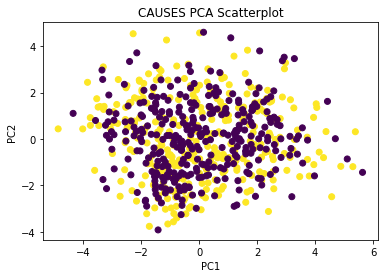

In [ ]:
plt.scatter(X[:,0], X[:,1],c=y)
plt.title('CAUSES PCA Scatterplot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

We can see above that there is no intepretable decision boundary between positive and negative pairs (at least not in 2-dimensional space).  There definitely seems to be spaces where pos embeddings appear, and other spaces where neg embeddings appear, so maybe there is a decision boundary in high-dimensional space, but we do not have enough data to reasonably fit that boundary.  

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=1000)
clf.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=1000, random_state=1)

In [ ]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.2748091603053435)

This does not work at all.  Not enough data + curse of dimensionality + text spans too large to fit neatly into a cross-encoder.

Now I want to see if we can make some cool word cloud visualizations of the semantic clusters.  

In [ ]:
from wordcloud import WordCloud

def makecloud(df, field_str):
  text = " ".join(passage for passage in df[field_str])
  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

kmeans_model = KMeans(n_clusters=6)
kmeans_model.fit(description_embeddings)
labels2 = kmeans_model.labels_
diseases['description_cluster_labels'] = labels2

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


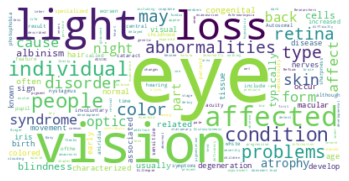

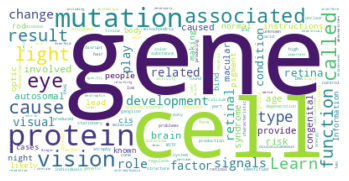

In [ ]:
diseases1 = diseases[diseases['description_cluster_labels'] == 0]
makecloud(diseases1, "description")
makecloud(diseases1, "causes")

One of the few clusters where the causes word cloud is a bit different.  We can see hormones in the causes word cloud and in the descriptions word cloud. (Note: this is no longer true since we changed our sentence encoder).  The semantic cluster seems pretty generic.  

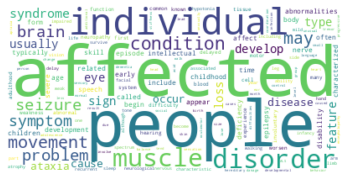

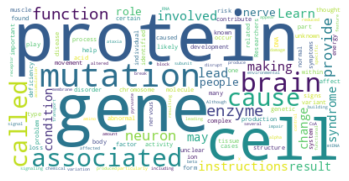

In [ ]:
diseases2 = diseases[diseases['description_cluster_labels'] == 1]
makecloud(diseases2, "description")
makecloud(diseases2, "causes")

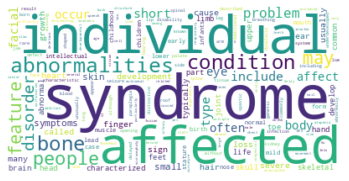

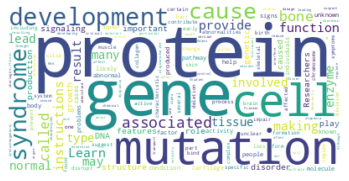

In [ ]:
diseases3 = diseases[diseases['description_cluster_labels'] == 2]
makecloud(diseases3, "description")
makecloud(diseases3, "causes")

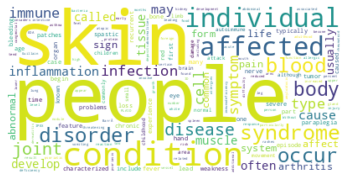

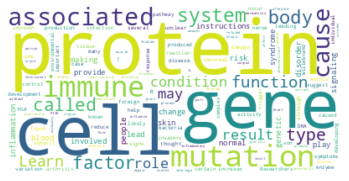

In [ ]:
diseases4 = diseases[diseases['description_cluster_labels'] == 3]
makecloud(diseases4, "description")
makecloud(diseases4, "causes")

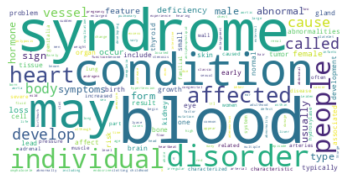

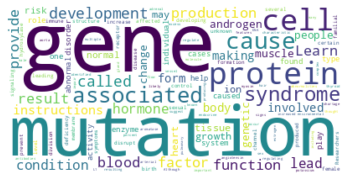

In [ ]:
diseases5 = diseases[diseases['description_cluster_labels'] == 4]
makecloud(diseases5, "description")
makecloud(diseases5, "causes")

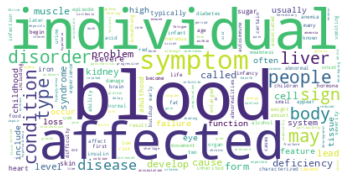

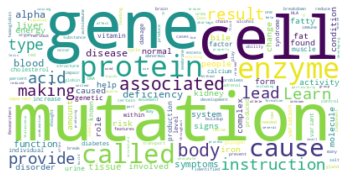

In [ ]:
diseases6 = diseases[diseases['description_cluster_labels'] == 5]
makecloud(diseases6, "description")
makecloud(diseases6, "causes")

Note, I actually thought we had more interesting world cloud results with the weaker sentence-bert. Its quite interesting that all-mpnet-base-v2 has much strong accuracy with the bi-encoder, while distillbert more intepretable results for topic modeling with semantic clustering.  The associated word clouds for causes don't show much of a difference since "gene" and "protein" and "mutation" are found in almost all the causes.  

Gonna do n-grams bi-encoder as a baseline.  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)
description_ngrams = tf.fit_transform(diseases['description'].values).toarray()
causes_ngrams = tf.transform(diseases['causes'].values).toarray()
causes_masked_ngrams = tf.transform(diseases['causes_masked'].values).toarray()

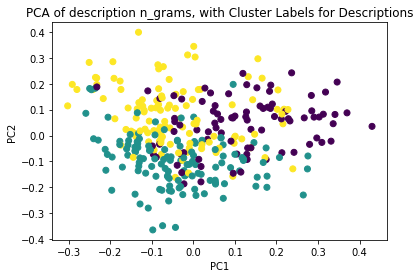

In [ ]:
pca3 = PCA(n_components=2)
components = pca3.fit_transform(description_ngrams)

plt.scatter(components[:,0], components[:,1],c=labels)
plt.title('PCA of description n_grams, with Cluster Labels for Descriptions')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
eval_bi_encoder(description_ngrams, causes_ngrams)
eval_bi_encoder(description_ngrams, causes_masked_ngrams)

Accuracy of BI-encoder: 0.9478527607361963
Accuracy of BI-encoder: 0.8496932515337423


N-grams turns out to be a pretty strong baseline for this task.  

Trying a version of bert trained on medical records.

In [ ]:
tz = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
medBert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
medBert = medBert.to(device)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def encode(disease_text, device):
  tokens = tz.encode_plus(
    text=disease_text,  # the sentence to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = 256,  # maximum length of a sentence
    pad_to_max_length=True,  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
    return_tensors = 'pt',  # ask the function to return Numpy tensors
  )
  tokens = tokens.to(device)
  encoding = medBert(**tokens)
  encoding = encoding.pooler_output.cpu().detach()
  torch.cuda.empty_cache()
  return encoding

In [ ]:
description_medbert = [encode(x, 'cuda').numpy().flatten() for x in diseases['description'].values]
causes_masked_medbert = [encode(x, 'cuda').numpy().flatten() for x in diseases['causes_masked'].values]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
eval_bi_encoder(description_medbert, causes_masked_medbert)

Accuracy of BI-encoder: 0.5552147239263804


Not good, i think the way the positions are messing up with it is part of the problem.

Lastly I want to try some simple contrastive learning on the embedding space.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold

# embs1 and embs2 must be same len!
def eval_CL(embs1, embs2):
  kf = KFold(n_splits=6, random_state=None, shuffle=True)
  cl_accs, gen_accs = [], []

  for i, (train_index, test_index) in enumerate(kf.split(embs1)):
    # calculate relation as vector difference between mean of classes
    rel = (embs1[train_index] - embs2[train_index]).mean(axis = 0)

    cl_accs.append(strong_eval_bi_encoder(embs1[test_index] - rel, 
                    embs2[test_index]))
    gen_accs.append(strong_eval_bi_encoder(embs1[test_index], 
                    embs2[test_index]))
    
  cl_accs, gen_accs = np.array(cl_accs), np.array(gen_accs)

  print("Contrastive Learning Accuracy:", cl_accs.mean())
  print("Contrastive Learning Accuracy STD:", cl_accs.std())
  print("Generic Accuracy", gen_accs.mean())
  print("Generic Accuracy STD", gen_accs.std())


In [ ]:
eval_CL(description_embeddings, causes_masked_embeddings)

Contrastive Learning Accuracy: 0.8332323232323232
Contrastive Learning Accuracy STD: 0.018784087006594927
Generic Accuracy 0.7200673400673402
Generic Accuracy STD 0.025270453792762222


Oooh! We actually get a considerable boost in accuracy by building a "causes_relation" vector and shifting the description embedding by this relation vector (3-4% boost in accuracy).

It would be interesting to plot the effects of CL!

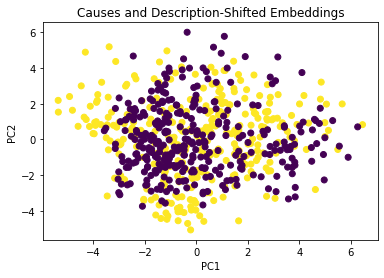

In [ ]:
rel = (description_embeddings - causes_masked_embeddings).mean(axis = 0)
pca_cl = PCA(n_components=2)
components1 = pca_cl.fit_transform(description_embeddings-rel)
components2 = pca_cl.fit_transform(causes_masked_embeddings-rel)

cd_pca =np.concatenate((components1, components2), axis=0)
cd_labels = np.array([1 for i in range(components1.shape[0])]
                     +[0 for i in range(components2.shape[0])])
plt.scatter(cd_pca[:,0], cd_pca[:,1],c=cd_labels)
plt.title('Causes and Description-Shifted Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

While not perfect, we maintain the distribution, and the causes and shift description embeddings are roughly on the same scale.  What is also somewhat counter-intuitive is that a shifting operation in high-dimensional space corresponds to a scaling operation when we perform PCA.  Very cool to learn!

In [ ]:
pca4 = PCA(n_components=300)
d_ngrams_dense = pca4.fit_transform(description_ngrams)
cm_ngrams_dense = pca4.transform(causes_masked_ngrams)
eval_CL(d_ngrams_dense, cm_ngrams_dense)

Contrastive Learning Accuracy: 0.9218237934904602
Contrastive Learning Accuracy STD: 0.01211521576126233
Generic Accuracy 0.9096127946127944
Generic Accuracy STD 0.015900359244926516


We see less of a CL boost for n-grams.

Want to try CL where the transform from the 'desc' space to the 'causes' space is a linear transform rather than a vector, though we may not have enough data to do this.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(description_embeddings, causes_masked_embeddings, test_size=0.15, random_state=42)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

causes_transform = MultiOutputRegressor(LinearRegression())
causes_transform.fit(X_train, y_train)
eval_bi_encoder(causes_transform.predict(X_test), y_test)

Accuracy of BI-encoder: 0.7346938775510204


Yeah not quite as good.  Probably not enough data, or maybe our embedding space is such that adding a relation vector is the best idea.  

pca improves ngrams model. We should be able to get a performance boost by stacking the models. TODO, will need some fixing up in dimension and magnitudes.

In [ ]:
pca5 = PCA(n_components=300)
d_embeds_dense = pca5.fit_transform(description_embeddings)
cm_embeds_dense = pca5.transform(causes_masked_embeddings)
eval_CL(d_embeds_dense, cm_embeds_dense)

Contrastive Learning Accuracy: 0.8312289562289562
Contrastive Learning Accuracy STD: 0.0547199124623395
Generic Accuracy 0.849523007856341
Generic Accuracy STD 0.05187778811399753


Need to condense both feature vectors to the same dimensionality (300) so they can have feature weight in the stacked model.  Notably, using PCA on embeddings (dim from 728-> 300) slightly increases the accuracy without contrastive learning, and doesn't impact contrastive learning accuracy.  

In [ ]:
def ave_embed_norm(embs):
  return np.array([np.linalg.norm(emb) for emb in embs]).mean()

print(ave_embed_norm(d_embeds_dense), ave_embed_norm(cm_embeds_dense)) 
print(ave_embed_norm(d_ngrams_dense), ave_embed_norm(cm_ngrams_dense))

7.4819064 9.791351
0.896128930920127 0.5034714925110239


embs are close enough in magnitude that I think we can go ahead and stack the embeddings.

In [ ]:
desc = np.concatenate((description_embeddings,d_ngrams_dense),axis=1)
caus = np.concatenate((causes_masked_embeddings,cm_ngrams_dense),axis=1)
eval_CL(desc,caus)


Contrastive Learning Accuracy: 0.834438832772166
Contrastive Learning Accuracy STD: 0.029900875668952956
Generic Accuracy 0.7369977553310886
Generic Accuracy STD 0.026223606345346907


This is our best method, but only slightly better than a strong SentenceBert model w CL.  This makes sense since a good SentenceBert model should have all n-gram information already stored within the encodings.  